## Accessing USGS Land Change Monitoring, Assessment, and Projection (LCMAP) with the Planetary Computer STAC API

The [U.S. Geological Survey (USGS) Land Change Monitoring, Assessment, and Projection (LCMAP)](https://www.usgs.gov/special-topics/lcmap) product provides land cover mapping and change monitoring from the USGS's Earth Resources Observation and Science (EROS) Center. LCMAP's Science Products are developed by applying time-series modeling on a per-pixel basis to Landsat Analysis Ready Data (ARD) using an implementation of the Continuous Change Detection and Classification (CCDC) algorithm. All available clear (non-cloudy) U.S. Landsat ARD observations are fit to a harmonic model to predict future Landsat-like surface reflectance. Where Landsat surface reflectance observations differ significantly from those predictions, a change is identified. Attributes of the resulting model sequences (e.g., start/end dates, residuals, model coefficients) are then used to produce a set of land surface change products and as inputs to the subsequent classification to thematic land cover.

Two LCMAP Collections are provided:

- LCMAP CONUS Collection 1.3, which was released in August 2022 for years 1985-2021.
- LCMAP Hawaii Collection 1.0, which was released in January 2022 for years 2000-2020.

The data are tiled according to the Landsat ARD tile grid and consist of Cloud Optimized GeoTIFFs (COGs) and corresponding metadata files. Note that the provided COGs differ slightly from those in the USGS source data. They have been reprocessed to add overviews, "nodata" values where appropriate, and an updated projection definition. The source USGS data bundle is also provided in TAR format.

Documentation for this dataset is available at the [Planetary Computer Data Catalog](https://planetarycomputer.microsoft.com/dataset/usgs-lcmap-conus-v13).

### Data Access
This notebook works with or without an API key, but you will be given more permissive access to the data with an API key. The [Planetary Computer Hub](https://planetarycomputer.microsoft.com/compute) sets the environment variable "PC_SDK_SUBSCRIPTION_KEY" when your server is started. The API key may be manually set via the following code:

```python
pc.settings.set_subscription_key(<YOUR API Key>)
```

The datasets hosted by the Planetary Computer are available in [Azure Blob Storage](https://docs.microsoft.com/en-us/azure/storage/blobs/). We'll use [pystac-client](https://pystac-client.readthedocs.io/) to search the Planetary Computer's [STAC API](https://planetarycomputer.microsoft.com/api/stac/v1/docs) for the subset of the data that we care about, and then we'll load the data directly from Azure Blob Storage. We'll specify a `modifier` so that we can access the data stored in the Planetary Computer's private Blob Storage Containers. See [Reading from the STAC API](https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/) and [Using tokens for data access](https://planetarycomputer.microsoft.com/docs/concepts/sas/) for more.

In [1]:
import planetary_computer
import pystac_client

# Open the Planetary Computer STAC API
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)
collection = catalog.get_collection(
    "usgs-lcmap-conus-v13"
)  # Available collections = "usgs-lcmap-conus-v13" and "usgs-lcmap-hawaii-v10"
print(collection)

<CollectionClient id=usgs-lcmap-conus-v13>


In [2]:
# Search the catalog and collection for desired items
latitude = 45.523064
longitude = -122.676483
Portland = [longitude, latitude]
geometry = {
    "type": "Point",
    "coordinates": Portland,
}

search = catalog.search(
    collections=collection, intersects=geometry, datetime="2020/2021"
)
items = list(search.get_items())
items

[<Item id=LCMAP_CU_003003_2021_V13_CCDC>,
 <Item id=LCMAP_CU_003003_2020_V13_CCDC>]

Each item includes a `rendered_preview` asset that can be used to quickly visualize the data using the Planetary Computer's data API.

In [3]:
from IPython.display import Image

Image(url=items[0].assets["rendered_preview"].href)

### Available Assets & Metadata

Let's display the available [assets](https://github.com/radiantearth/stac-spec/blob/master/item-spec/item-spec.md#asset-object) and metadata. 

In [4]:
import rich.table

# Assets
t_assets = rich.table.Table("Key", "Value")
for key, asset in items[0].assets.items():
    t_assets.add_row(key, asset.title)
t_assets

┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Key              ┃ Value                                    ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ dates            │ Landsat Observation Dates                │
│ lcpri            │ Primary Land Cover                       │
│ lcsec            │ Secondary Land Cover                     │
│ scmag            │ Change Magnitude                         │
│ scmqa            │ Model Quality                            │
│ browse           │ USGS Browse Image                        │
│ lcachg           │ Annual Land Cover Change                 │
│ sclast           │ Time Since Last Change                   │
│ scstab           │ Spectral Stability Period                │
│ sctime           │ Time of Spectral Change                  │
│ lcpconf          │ Primary Land Cover Confidence            │
│ lcsconf          │ Secondary Land Cover Confidence          │
│ lcpri_metadata   │ Primary Land Cover Metadata              │
│ lcsec_metadata   │ Secondary Land Cover Metadata            │
│ scmag_metadata   │ Change Magnitude Metadata                │
│ scmqa_metadata   │ Model Quality Metadata                   │
│ lcachg_metadata  │ Annual Land Cover Change Metadata        │
│ sclast_metadata  │ Time Since Last Change Metadata          │
│ scstab_metadata  │ Spectral Stability Period Metadata       │
│ sctime_metadata  │ Time of Spectral Change Metadata         │
│ lcpconf_metadata │ Primary Land Cover Confidence Metadata   │
│ lcsconf_metadata │ Secondary Land Cover Confidence Metadata │
│ tilejson         │ TileJSON with default rendering          │
│ rendered_preview │ Rendered preview                         │
└──────────────────┴──────────────────────────────────────────┘

In [5]:
# Metadata
t_metadata = rich.table.Table("Key", "Value")
for k, v in sorted(items[0].properties.items()):
    t_metadata.add_row(k, str(v))
t_metadata

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Key                        ┃ Value                                                                              ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ created                    │ 2023-01-12T21:43:11.362260Z                                                        │
│ datetime                   │ None                                                                               │
│ end_datetime               │ 2021-12-31T23:59:59Z                                                               │
│ grid:code                  │ LARD-003003                                                                        │
│ proj:epsg                  │ None                                                                               │
│ proj:shape                 │ [5000, 5000]                                                                       │
│ proj:transform             │ [30.0, 0.0, -2115585.0, 0.0, -30.0, 2864805.0]                                     │
│ proj:wkt2                  │ PROJCS["AEA        WGS84",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS           │
│                            │ 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRI… │
│ start_datetime             │ 2021-01-01T00:00:00Z                                                               │
│ title                      │ LCMAP CONUS Collection 1.3 Land Cover and Land Change Products for Tile 003003,    │
│                            │ Year 2021                                                                          │
│ usgs_lcmap:collection      │ CONUS 1.3                                                                          │
│ usgs_lcmap:horizontal_tile │ 3                                                                                  │
│ usgs_lcmap:vertical_tile   │ 3                                                                                  │
└────────────────────────────┴────────────────────────────────────────────────────────────────────────────────────┘

### Loading the gridded data
Now let's load STAC items into an xarray dataset using [odc-stac](https://github.com/opendatacube/odc-stac).

In [6]:
import odc.stac

ds = odc.stac.load(items, chunks={})
ds

<xarray.Dataset>
Dimensions:      (y: 5001, x: 5001, time: 2)
Coordinates:
  * y            (y) float64 2.865e+06 2.865e+06 ... 2.715e+06 2.715e+06
  * x            (x) float64 -2.116e+06 -2.116e+06 ... -1.966e+06 -1.966e+06
    spatial_ref  int32 0
  * time         (time) datetime64[ns] 2020-01-01 2021-01-01
Data variables:
    lcpri        (time, y, x) uint8 dask.array<chunksize=(1, 5001, 5001), meta=np.ndarray>
    lcsec        (time, y, x) uint8 dask.array<chunksize=(1, 5001, 5001), meta=np.ndarray>
    scmag        (time, y, x) float32 dask.array<chunksize=(1, 5001, 5001), meta=np.ndarray>
    scmqa        (time, y, x) uint8 dask.array<chunksize=(1, 5001, 5001), meta=np.ndarray>
    browse       (time, y, x) uint8 dask.array<chunksize=(1, 5001, 5001), meta=np.ndarray>
    lcachg       (time, y, x) uint8 dask.array<chunksize=(1, 5001, 5001), meta=np.ndarray>
    sclast       (time, y, x) uint16 dask.array<chunksize=(1, 5001, 5001), meta=np.ndarray>
    scstab       (time, y, x) uint16 dask.array<chunksize=(1, 5001, 5001), meta=np.ndarray>
    sctime       (time, y, x) uint16 dask.array<chunksize=(1, 5001, 5001), meta=np.ndarray>
    lcpconf      (time, y, x) uint8 dask.array<chunksize=(1, 5001, 5001), meta=np.ndarray>
    lcsconf      (time, y, x) uint8 dask.array<chunksize=(1, 5001, 5001), meta=np.ndarray>

### Displaying the data

This dataset includes a preferred colormap mapping raster values to colors. The Collection's `item_assets` field includes an overview of the class descriptions and values.

In [7]:
from pystac.extensions.item_assets import ItemAssetsExtension

ia = ItemAssetsExtension.ext(collection)
x = ia.item_assets["lcpri"]

class_names = {
    x["description"]: x["value"] for x in x.properties["classification:classes"]
}
class_values = {v: k for k, v in class_names.items()}

t = rich.table.Table("Description", "Value")
for k, v in class_names.items():
    t.add_row(k, str(v))
t

┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Description ┃ Value ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ No Data     │ 0     │
│ Developed   │ 1     │
│ Cropland    │ 2     │
│ Grass/Shrub │ 3     │
│ Tree Cover  │ 4     │
│ Water       │ 5     │
│ Wetlands    │ 6     │
│ Snow/Ice    │ 7     │
│ Barren      │ 8     │
└─────────────┴───────┘

And the Planetary Computer's [Data API](https://planetarycomputer.microsoft.com/api/data/v1/docs) includes the colormap. We'll convert those values to a [matplotlib Colormap](https://matplotlib.org/stable/api/_as_gen/matplotlib.colors.ListedColormap.html) for plotting.

In [8]:
import requests

classmap = requests.get(
    "https://planetarycomputer.microsoft.com/api/data/v1/legend/classmap/usgs-lcmap"
).json()

# Filter xarray for primary classification data
# i.e. No Data, Developed, Cropland, Grass/Shrub, Tree Cover, Water, Wetlands, Snow/Ice, Baren
classmap_filtered = {k: v for k, v in classmap.items() if v != [171, 0, 214, 255]}
print(classmap_filtered)

{'0': [0, 0, 0, 0], '1': [255, 50, 50, 255], '2': [190, 140, 90, 255], '3': [230, 240, 210, 255], '4': [28, 99, 48, 255], '5': [0, 112, 255, 255], '6': [179, 217, 255, 255], '7': [255, 255, 255, 255], '8': [179, 174, 163, 255]}


In [9]:
import matplotlib.colors
import numpy as np
import pandas as pd
import requests

colors = [
    matplotlib.colors.to_rgba([x / 255 for x in c]) for c in classmap_filtered.values()
]
cmap = matplotlib.colors.ListedColormap(colors, name="usgs-lcmap")
ticks = np.arange(cmap.N)
labels = [class_values.get(value, "nodata") for value in ticks]

Finally, we can read and plot the data. 

In [10]:
lcpri = ds["lcpri"].isel(time=-1).load()

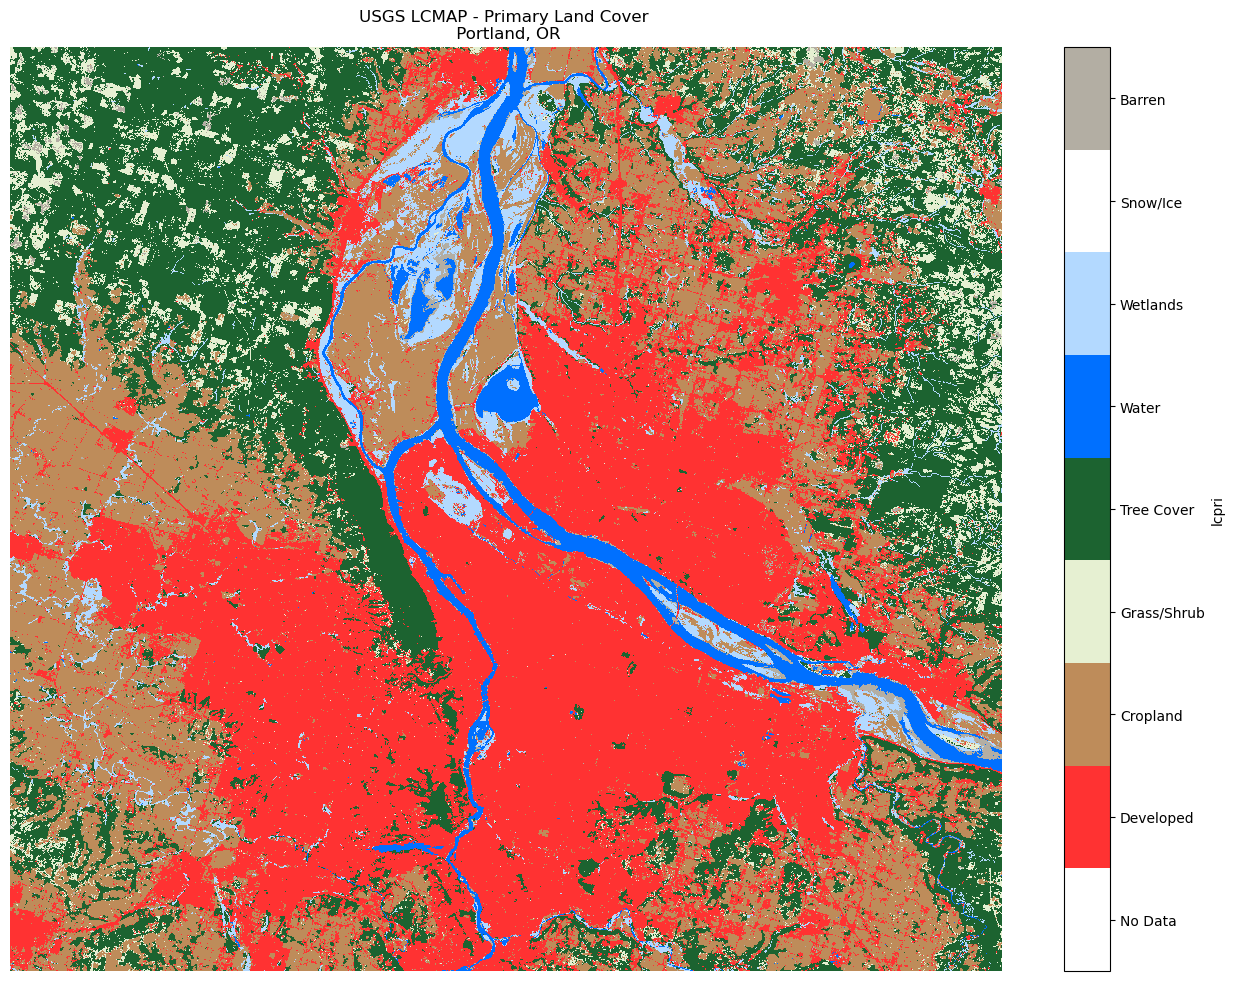

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 12))

p = lcpri.isel(x=slice(1000, 3000), y=slice(1000, 3000)).plot(
    ax=ax,
    cmap=cmap,
    norm=matplotlib.colors.NoNorm(),
)

ax.set_axis_off()
ax.set_title("USGS LCMAP - Primary Land Cover \n Portland, OR")

colorbar = fig.axes[1]
colorbar.set_yticks(ticks, labels=labels);

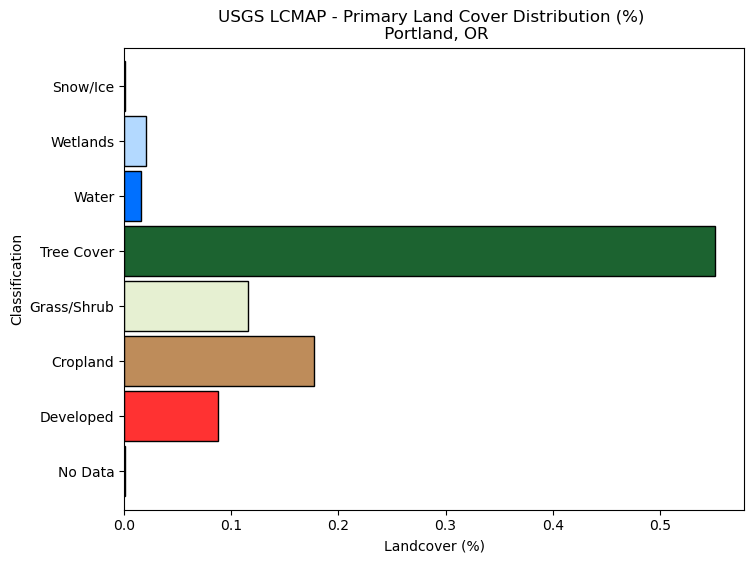

In [12]:
ax = plt.figure(figsize=(8, 6), dpi=100).gca()

colors = list(cmap.colors)

df = (
    pd.value_counts(lcpri.data.ravel(), sort=False, normalize=True)
    .sort_index()
    .reindex(range(0, 8), fill_value=0)
    .rename(dict(enumerate(class_names, start=0)))
)
df.plot.barh(ax=ax, color=colors, rot=0, width=0.9, linewidth=1, edgecolor="black")

ax.set(
    title="USGS LCMAP - Primary Land Cover Distribution (%) \n Portland, OR",
    ylabel="Classification",
    xlabel="Landcover (%)",
    facecolor="white",
);